# Enrichment in DE genes

In [1]:
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

## Functions

### Cached functions

In [2]:
@functools.lru_cache()
def get_wgcna_modules():
    return pd.read_csv("../../_m/modules.csv", index_col=0)


@functools.lru_cache()
def get_degs():
    return set(pd.read_csv('../../../../differential_analysis/'+\
                           'dlpfc/_m/genes/diffExpr_EAvsAA_FDR05.txt',
                           sep='\t', usecols=[0], index_col=0).index)


@functools.lru_cache()
def get_mhc_genes():
    return set(pd.read_csv('../../../../input/counts/mhc_region_genes/'+\
                           '_m/mhc_genes.csv')['gene_id'])

### Simple functions

In [3]:
def fet(a, b, u):
    # a, b, u are sets
    # u is the universe
    yes_a = u.intersection(a)
    yes_b = u.intersection(b)
    no_a = u - a
    no_b = u - b
    m = [[len(yes_a.intersection(yes_b)), len(no_a.intersection(yes_b)) ], 
         [len(yes_a.intersection(no_b)), len(no_a.intersection(no_b))]]
    return fisher_exact(m)


def enrichment_rows():
    mod = get_wgcna_modules().module.unique()
    u = set(get_wgcna_modules().index) 
    for ii in range(len(mod)): # for each module
        a = set(get_wgcna_modules()[(get_wgcna_modules().module) == mod[ii]].index)
        b = set(get_wgcna_modules()[(get_wgcna_modules().module) == mod[ii]].index) - get_mhc_genes()
        yield (mod[ii],
               len(a),
               *fet(a, get_degs(), u),
               *fet(b, get_degs() - get_mhc_genes(), u),
               )


## Main

### Enrichment

In [4]:
edf = pd.DataFrame.from_records(enrichment_rows(), 
                                 columns=['Module_ID', 'N_Genes', 'DEG_OR', 'DEG_P', 
                                          'DEG_noMHC_OR', 'DEG_noMHC_P'],
                                 index='Module_ID')
edf['DEG_FDR'] = multipletests(edf['DEG_P'], method='fdr_bh')[1]
edf['DEG_noMHC_FDR'] = multipletests(edf['DEG_noMHC_P'], method='fdr_bh')[1]
edf = edf.loc[:, ['N_Genes', 'DEG_OR', 'DEG_P', 'DEG_FDR', 'DEG_noMHC_OR', 'DEG_noMHC_P', 'DEG_noMHC_FDR']]

In [5]:
print(edf[(edf["DEG_FDR"] < 0.05)].shape)
edf[(edf["DEG_FDR"] < 0.05)]

(20, 7)


,N_Genes,DEG_OR,DEG_P,DEG_FDR,DEG_noMHC_OR,DEG_noMHC_P,DEG_noMHC_FDR
Module_ID,,,,,,,
grey,9301,1.381842,2.557465e-15,2.109908e-14,1.413304,3.656371e-17,3.016506e-16
cyan,387,2.641789,1.448431e-14,7.966372e-14,2.620217,3.604968e-14,1.982733e-13
blue,1086,0.623003,1.019720e-05,4.807252e-05,0.631043,1.787571e-05,8.427120e-05
pink,498,0.667243,1.057143e-02,1.744287e-02,0.669036,1.184407e-02,1.954272e-02
purple,423,0.518651,3.136625e-04,8.625719e-04,0.512765,2.712386e-04,7.459062e-04
darkgrey,185,0.361765,1.000292e-03,2.539203e-03,0.371172,1.339033e-03,3.156293e-03
turquoise,2005,0.464224,1.675530e-19,1.843083e-18,0.465871,3.160914e-19,5.215508e-18
royalblue,236,0.345246,8.895660e-05,2.736170e-04,0.352893,1.693397e-04,5.080192e-04
darkturquoise,188,4.507851,8.189218e-20,1.351221e-18,4.626529,2.639454e-20,8.710198e-19


In [6]:
print(edf[(edf["DEG_noMHC_FDR"] < 0.05)].shape)
set(edf[(edf["DEG_FDR"] < 0.05)].index) - set(edf[(edf["DEG_noMHC_FDR"] < 0.05)].index)

(20, 7)


set()

#### sienna3 is enriched in MHC differentially expressed genes

In [7]:
edf.to_csv('wgcna_module_enrichment.csv')

### Plot heatmap

<AxesSubplot:title={'center':'Enrichment/depletion DE genes in WGCNA modules\n(FDR values)'}>

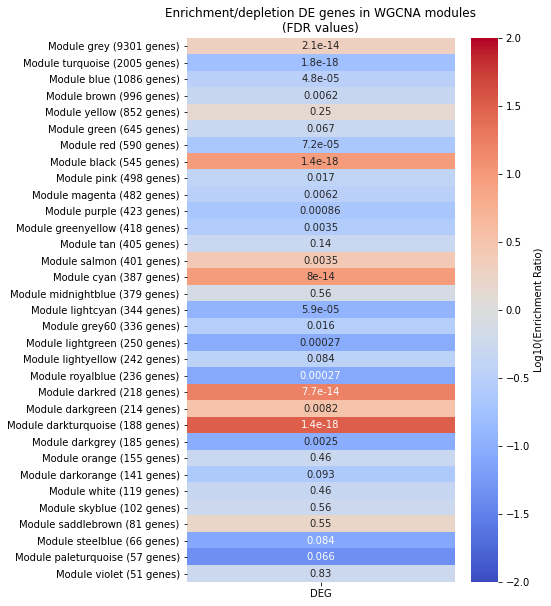

In [8]:
df = edf.sort_values("N_Genes", ascending=False)
df2 = np.log(df.loc[:, ['DEG_OR']]).replace([np.inf, -np.inf], 0)
df2.columns = ['DEG']
df2.index = ["Module %s (%d genes)" % (x,y) for x,y in zip(df2.index, df['N_Genes'])]
df3 = df.loc[:, ['DEG_FDR']]

fig, ax = plt.subplots(figsize=(6,10))
p = sns.heatmap(df2, cmap='coolwarm', annot=df3, yticklabels=df2.index, center=0,
                cbar_kws={'label': 'Log10(Enrichment Ratio)'}, vmin=-2, vmax=2)
p.set_title("Enrichment/depletion DE genes in WGCNA modules\n(FDR values)")
p.get_figure().savefig('wgcna_module_enrichment.pdf', bbox_inches='tight')
p

<AxesSubplot:title={'center':'Enrichment/depletion DE genes in WGCNA modules\n(FDR values)'}>

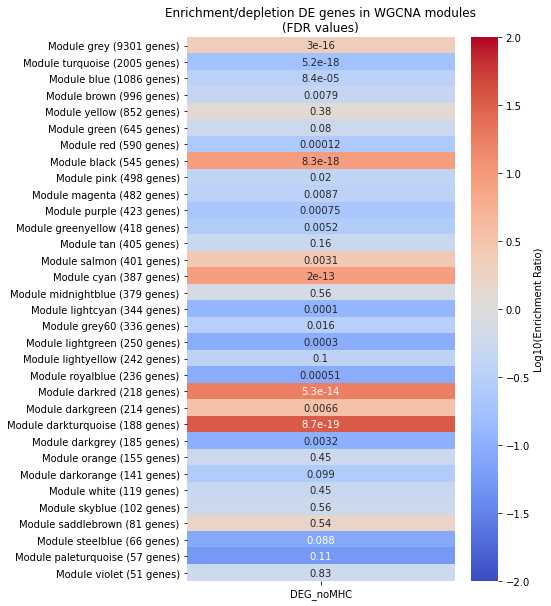

In [9]:
df = edf.sort_values("N_Genes", ascending=False)
df2 = np.log(df.loc[:, ['DEG_noMHC_OR']]).replace([np.inf, -np.inf], 0)
df2.columns = ['DEG_noMHC']
df2.index = ["Module %s (%d genes)" % (x,y) for x,y in zip(df2.index, df['N_Genes'])]
df3 = df.loc[:, ['DEG_noMHC_FDR']]

fig, ax = plt.subplots(figsize=(6,10))
p = sns.heatmap(df2, cmap='coolwarm', annot=df3, yticklabels=df2.index, center=0,
                cbar_kws={'label': 'Log10(Enrichment Ratio)'}, vmin=-2, vmax=2)
p.set_title("Enrichment/depletion DE genes in WGCNA modules\n(FDR values)")
p.get_figure().savefig('wgcna_module_enrichment_noMHC.pdf', bbox_inches='tight')
p